In [6]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score



In [8]:
#  Load metadata
metadata_path = "./Baxter_data/crc_baxter.metadata.txt"
metadata = pd.read_csv(metadata_path, sep='\t', low_memory=False, encoding='ISO-8859-1')

#  Inspect metadata
print("Metadata shape:", metadata.shape)
print("Columns:", metadata.columns.tolist())
metadata.head()


Metadata shape: (490, 73)
Columns: ['Sample_Name_s', 'Abx_s', 'Age_s', 'Asian_s', 'BMI_s', 'BioSample_s', 'Black_s', 'Diabetes_Med_s', 'Diabetic_s', 'Ethnic_s', 'Experiment_s', 'Gender_s', 'Height_s', 'Hx_Fam_CRC_s', 'Hx_Prev_s', 'Hx_of_Polyps_s', 'Library_Name_s', 'MBases_l', 'MBytes_l', 'NSAID_s', 'Native_s', 'Organism_s', 'Other_s', 'Pacific_s', 'Run_s', 'SRA_Sample_s', 'Smoke_s', 'Weight_s', 'White_s', 'cancer_stage_s', 'chimera_check_s', 'description_s', 'diagnosis_s', 'env_biome_s', 'env_feature_s', 'env_material_s', 'fit_result_s', 'geo_loc_name_s', 'host_s', 'lib_const_meth_s', 'organism_s', 'pcr_cond_s', 'pcr_primers_s', 'samp_collect_device_s', 'samp_store_temp_s', 'sample_title_s', 'seq_methods_s', 'seq_qual_check_s', 'target_gene_s', 'target_subfragment_s', 'Assay_Type_s', 'AssemblyName_s', 'BioProject_s', 'BioSampleModel_s', 'Center_Name_s', 'Consent_s', 'InsertSize_l', 'LibraryLayout_s', 'LibrarySelection_s', 'LibrarySource_s', 'LoadDate_s', 'Platform_s', 'ReleaseDate_s',

,Sample_Name_s,Abx_s,Age_s,Asian_s,BMI_s,BioSample_s,Black_s,Diabetes_Med_s,Diabetic_s,Ethnic_s,...,SRA_Study_s,g1k_analysis_group_s,g1k_pop_code_s,source_s,dataset,sequencer,region,total_reads,study,DiseaseState
0,2005650,0,61,0,28.0,SAMN03939372,0,0,0,0,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,1185,crc_baxter,H
1,2003650,0,64,0,36.2,SAMN03939371,0,0,0,0,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,1536,crc_baxter,H
2,2027653,0,65,0,21.5,SAMN03939381,0,0,0,1,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,6330,crc_baxter,H
3,2025653,0,67,0,20.8,SAMN03939380,0,0,0,0,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,18095,crc_baxter,CRC
4,2023680,0,63,0,22.8,SAMN03939379,0,0,0,0,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,4535,crc_baxter,H


In [21]:
#  Load OTU table
otu_table_path = "./Baxter_data/Baxter_OTU_table"
otu_table = pd.read_csv(otu_table_path, sep='\t', low_memory=False)

# 🧾 Inspect OTU data
print("OTU table shape:", otu_table.shape)
print("Preview of OTU table:")
otu_table.head()
missing_values = otu_table.isnull().sum()
missing_values = missing_values[missing_values > 0]
otu_table.head()


OTU table shape: (490, 9471)
Preview of OTU table:


,label,Group,numOtus,Otu000001,Otu000002,Otu000003,Otu000004,Otu000005,Otu000006,Otu000007,...,Otu009459,Otu009460,Otu009461,Otu009462,Otu009463,Otu009464,Otu009465,Otu009466,Otu009467,Unnamed: 9470
0,0.03,2003650,9467,660,508,519,424,475,1287,425,...,0,0,0,0,0,0,0,0,0,NaN
1,0.03,2005650,9467,777,927,1818,355,150,571,19,...,0,0,0,0,0,0,0,0,0,NaN
2,0.03,2007660,9467,333,542,1752,1326,827,141,1845,...,0,0,0,0,0,0,0,0,0,NaN
3,0.03,2009650,9467,494,325,47,359,291,395,1893,...,0,0,0,0,0,0,0,0,0,NaN
4,0.03,2013660,9467,5141,34,660,2272,4145,2048,3,...,0,0,0,0,0,0,0,0,0,NaN


In [22]:

if not missing_values.empty:
    print("Columns with missing values and their counts:")
    print(missing_values)
    
    # Drop fully missing columns
    cols_to_drop = missing_values[missing_values == otu_table.shape[0]].index
    otu_table.drop(columns=cols_to_drop, inplace=True)
    print(f"✅ Dropped {len(cols_to_drop)} columns with all missing values.")
else:
    print("No missing values detected.")

print(f"OTU table shape after cleaning: {otu_table.shape}")

Columns with missing values and their counts:
Unnamed: 9470    490
dtype: int64
✅ Dropped 1 columns with all missing values.
OTU table shape after cleaning: (490, 9470)


In [23]:
# Rename column in metadata to match OTU table for merging
metadata.rename(columns={'Sample_Name_s': 'Group'}, inplace=True)

# Merge OTU table with metadata using the common 'Group' column
combined_data = pd.merge(otu_table, metadata, on='Group')

# Inspect merged data
print(f"Combined data shape: {combined_data.shape}")
display(combined_data.head())

# Check for missing values
missing_values = combined_data.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    print("Columns with missing values and their counts:")
    print(missing_values)
else:
    print("No missing values detected.")


Combined data shape: (490, 9542)


,label,Group,numOtus,Otu000001,Otu000002,Otu000003,Otu000004,Otu000005,Otu000006,Otu000007,...,SRA_Study_s,g1k_analysis_group_s,g1k_pop_code_s,source_s,dataset,sequencer,region,total_reads,study,DiseaseState
0,0.03,2003650,9467,660,508,519,424,475,1287,425,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,1536,crc_baxter,H
1,0.03,2005650,9467,777,927,1818,355,150,571,19,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,1185,crc_baxter,H
2,0.03,2007660,9467,333,542,1752,1326,827,141,1845,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,4911,crc_baxter,H
3,0.03,2009650,9467,494,325,47,359,291,395,1893,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,1353,crc_baxter,nonCRC
4,0.03,2013660,9467,5141,34,660,2272,4145,2048,3,...,SRP062005,<not provided>,<not provided>,<not provided>,crc_baxter,Miseq,V4,18206,crc_baxter,H


Columns with missing values and their counts:
cancer_stage_s    370
dtype: int64


In [25]:
# Define OTU feature columns (exclude metadata columns)
otu_columns = otu_table.columns[3:]
print(f"✅ Number of OTU columns: {len(otu_columns)}")
print("Sample OTU column names:", otu_columns[:5].tolist(), "...")


✅ Number of OTU columns: 9467
Sample OTU column names: ['Otu000001', 'Otu000002', 'Otu000003', 'Otu000004', 'Otu000005'] ...


In [26]:
# Define features (OTUs) and target variable (DiseaseState)
X = combined_data[otu_columns]
y = combined_data['DiseaseState']

# Split data into training and testing sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check class distribution
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True).round(3))

print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True).round(3))


Class distribution in training set:
DiseaseState
nonCRC    0.403
H         0.352
CRC       0.245
Name: proportion, dtype: float64

Class distribution in testing set:
DiseaseState
nonCRC    0.408
H         0.347
CRC       0.245
Name: proportion, dtype: float64


## Feature Reduction via Prevalence and Variance Thresholds

To reduce noise from sparse and non-informative OTUs:

- OTUs were first filtered based on their presence across samples (prevalence).
- Then, each sample's OTU abundances were normalized.
- Finally, features with very low variance across samples were removed.

We explored a range of prevalence and variance thresholds to assess feature retention, then selected the combination that preserved informative diversity without overfitting.


In [48]:

# Custom Transformers
class OTUThresholdFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold

    def fit(self, X, y=None):
        presence_counts = (X > 0).sum(axis=0)
        self.otus_above_threshold_ = presence_counts[
            presence_counts >= self.threshold * X.shape[0]
        ].index
        return self

    def transform(self, X):
        return X[self.otus_above_threshold_]

class Normalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.div(X.sum(axis=1), axis=0)

# Pipeline setup
preprocessing_pipeline = Pipeline([
    ('otu_filter', OTUThresholdFilter()),
    ('normalizer', Normalizer()),
    ('variance_filter', VarianceThreshold())
])

# Explore parameter combinations
param_grid = {
    'otu_filter__threshold': [0.05, 0.01, 0.005],
    'variance_filter__threshold': [1e-8, 5e-7, 1e-6]
}

results = []
for params in ParameterGrid(param_grid):
    preprocessing_pipeline.set_params(**params)
    X_train_pre = preprocessing_pipeline.fit_transform(X_train)
    X_test_pre = preprocessing_pipeline.transform(X_test)
    
    results.append({
        'params': params,
        'num_features': X_train_pre.shape[1],
        'train_shape': X_train_pre.shape,
        'test_shape': X_test_pre.shape
    })

# Show results
for result in results:
    print(f"Parameters: {result['params']}")
    print(f"Number of Features: {result['num_features']}")
    print(f"Training Shape: {result['train_shape']}")
    print(f"Testing Shape: {result['test_shape']}")
    print("-----")




Parameters: {'otu_filter__threshold': 0.05, 'variance_filter__threshold': 1e-08}
Number of Features: 303
Training Shape: (392, 303)
Testing Shape: (98, 303)
-----
Parameters: {'otu_filter__threshold': 0.05, 'variance_filter__threshold': 5e-07}
Number of Features: 303
Training Shape: (392, 303)
Testing Shape: (98, 303)
-----
Parameters: {'otu_filter__threshold': 0.05, 'variance_filter__threshold': 1e-06}
Number of Features: 268
Training Shape: (392, 268)
Testing Shape: (98, 268)
-----
Parameters: {'otu_filter__threshold': 0.01, 'variance_filter__threshold': 1e-08}
Number of Features: 372
Training Shape: (392, 372)
Testing Shape: (98, 372)
-----
Parameters: {'otu_filter__threshold': 0.01, 'variance_filter__threshold': 5e-07}
Number of Features: 372
Training Shape: (392, 372)
Testing Shape: (98, 372)
-----
Parameters: {'otu_filter__threshold': 0.01, 'variance_filter__threshold': 1e-06}
Number of Features: 318
Training Shape: (392, 318)
Testing Shape: (98, 318)
-----
Parameters: {'otu_filt

In [29]:
# Apply final selected parameters
best_params = {'otu_filter__threshold': 0.005, 'variance_filter__threshold': 5e-7}
preprocessing_pipeline.set_params(**best_params)

X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

# Extract selected OTU features
filtered_otus = preprocessing_pipeline.named_steps['otu_filter'].otus_above_threshold_
selected_features = filtered_otus[preprocessing_pipeline.named_steps['variance_filter'].get_support()]

# Save as DataFrames
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=selected_features, index=X_train.index)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=selected_features, index=X_test.index)

X_train_preprocessed_df.to_csv('X_train_preprocessed.csv', index=False)
X_test_preprocessed_df.to_csv('X_test_preprocessed.csv', index=False)

# Final summary
print(f"Final OTUs in Training Set: {X_train_preprocessed_df.shape[1]}")
print(f"Final OTUs in Testing Set: {X_test_preprocessed_df.shape[1]}")


Final OTUs in Training Set: 385
Final OTUs in Testing Set: 385


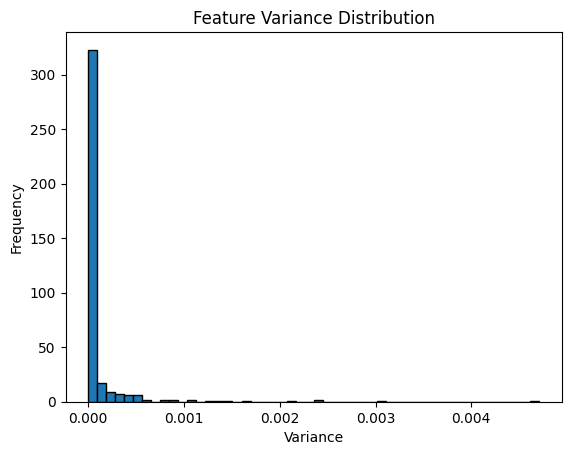

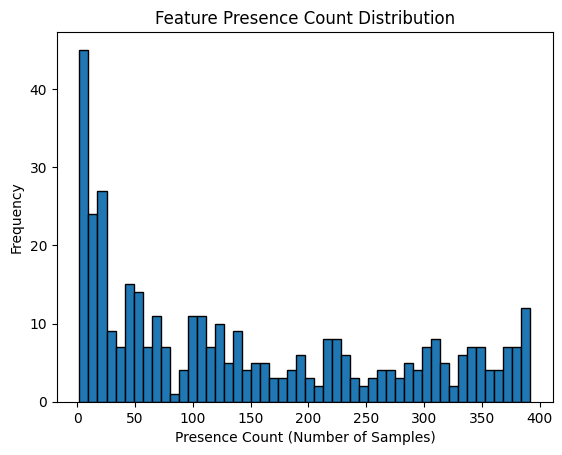

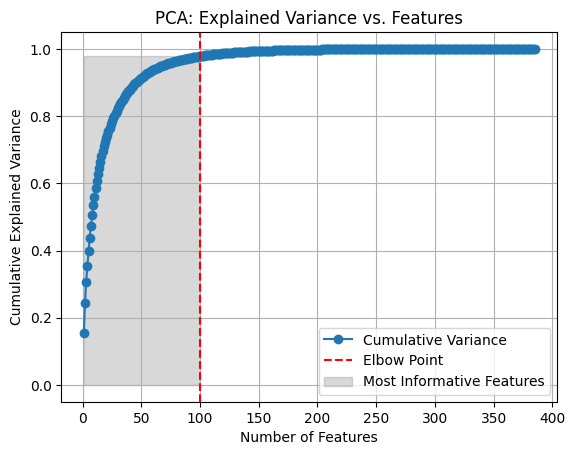

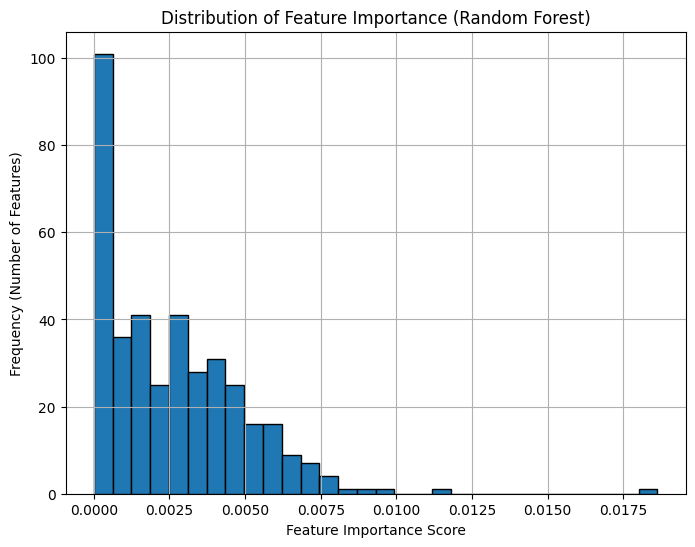

In [49]:
# Feature distribution and importance visualizations for OTU data

### features visualization########

X_train=X_train_preprocessed_df

def plot_variance_histogram(X_train):
    """Plots a histogram of feature variances."""
    variances = X_train.var(axis=0)
    plt.figure()
    plt.hist(variances, bins=50, edgecolor='k')
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.title('Feature Variance Distribution')
    plt.show()

def plot_presence_histogram(X_train):
    """Plots a histogram of feature presence counts."""
    presence_counts = (X_train > 0).sum(axis=0)
    plt.figure()
    plt.hist(presence_counts, bins=50, edgecolor='k')
    plt.xlabel('Presence Count (Number of Samples)')
    plt.ylabel('Frequency')
    plt.title('Feature Presence Count Distribution')
    plt.show()


def plot_pca_variance(X_train):
    """Plots PCA cumulative explained variance."""
    pca = PCA()
    pca.fit(X_train)
    
    # Find the elbow point (manually adjust or automate using a method)
    elbow_point = 100  # Adjust based on your observation
    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    plt.figure()
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label="Cumulative Variance")
    plt.axvline(x=elbow_point, color='r', linestyle='--', label="Elbow Point")
    
    # Add shading
    plt.fill_between(range(1, elbow_point + 1), 0, cumulative_variance[elbow_point - 1], color='gray', alpha=0.3, label="Most Informative Features")
    
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA: Explained Variance vs. Features')
    plt.legend()
    plt.grid()
    plt.show()
    

def plot_feature_importance(X_train, y_train):
    """Plots feature importance using a Random Forest model."""
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = model.feature_importances_

    # Plot histogram of importance scores
    plt.figure(figsize=(8, 6))
    plt.hist(feature_importances, bins=30, edgecolor='k')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Frequency (Number of Features)')
    plt.title('Distribution of Feature Importance (Random Forest)')
    plt.grid(True)
    plt.show()
    


def run_all_visualizations(X_train, y_train):
    """Runs all visualization functions."""
    plot_variance_histogram(X_train)
    plot_presence_histogram(X_train)
    plot_pca_variance(X_train)
    plot_feature_importance(X_train, y_train)
    
run_all_visualizations(X_train, y_train)

###  Feature Reduction Considerations  

After initial filtering, **385 OTUs** remain, which is still a high-dimensional feature set.  
From a biological perspective, we know that the **core gut microbiome** of an individual consists of a relatively **small, stable subset of taxa** that do not fluctuate significantly over time.  

 **Why Further Reduction?**  
- The **core gut microbiome** is often estimated to consist of **~50–60 robust OTUs**, though this varies between studies and populations.  
- **Limited sample size** makes it crucial to reduce the number of features to prevent overfitting.  
- A feature set of **<100 OTUs** is more interpretable and computationally efficient while retaining predictive power.  

 **Next Steps:** We will apply **LASSO regression** and **Random Forest feature selection** to further refine the OTU list and retain only the most predictive features.  


In [50]:
#  Prepare data for binary classification (e.g., H vs CRC, H vs nonCRC)
def prepare_binary_data(X_train, y_train, X_test, y_test, positive_class, negative_class, positive_label):
    """
    Filters and relabels training/testing sets for binary classification.

    Parameters:
        - X_train, X_test: Feature DataFrames
        - y_train, y_test: Labels (DiseaseState)
        - positive_class: Label to be treated as class 1 (or 2)
        - negative_class: Label to be treated as class 0
        - positive_label: int, either 1 or 2 depending on the classification

    Returns:
        - X_train_bin, y_train_bin, X_test_bin, y_test_bin
    """
    # Combine features and labels
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)

    # Filter for binary labels
    binary_train = train_data[train_data['DiseaseState'].isin([negative_class, positive_class])].copy()
    binary_test = test_data[test_data['DiseaseState'].isin([negative_class, positive_class])].copy()

    # Relabel: negative_class = 0, positive_class = positive_label (usually 1 or 2)
    label_map = {negative_class: 0, positive_class: positive_label}
    binary_train['DiseaseState'] = binary_train['DiseaseState'].map(label_map)
    binary_test['DiseaseState'] = binary_test['DiseaseState'].map(label_map)

    # Split back into X/y
    X_train_bin = binary_train.drop('DiseaseState', axis=1)
    y_train_bin = binary_train['DiseaseState']
    X_test_bin = binary_test.drop('DiseaseState', axis=1)
    y_test_bin = binary_test['DiseaseState']

    return X_train_bin, y_train_bin, X_test_bin, y_test_bin

# 🧪 Prepare datasets: H vs CRC and H vs nonCRC
X_train_crc, y_train_crc, X_test_crc, y_test_crc = prepare_binary_data(
    X_train_preprocessed_df, y_train, X_test_preprocessed_df, y_test,
    positive_class='CRC', negative_class='H', positive_label=1
)

X_train_noncrc, y_train_noncrc, X_test_noncrc, y_test_noncrc = prepare_binary_data(
    X_train_preprocessed_df, y_train, X_test_preprocessed_df, y_test,
    positive_class='nonCRC', negative_class='H', positive_label=2
)


In [39]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Utility: Select top N features using Random Forest
def get_top_rf_features(X_train, y_train, N, filename):
    """
    Trains a Random Forest classifier and selects top N most important features.

    Parameters:
        - X_train (DataFrame): Training features
        - y_train (Series): Binary target labels
        - N (int): Number of top features to select
        - filename (str): Path to save top feature rankings (CSV)

    Returns:
        selected_features (list): List of selected feature names
    """
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)

    # Extract and rank feature importances
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(N)

    # Save ranked features
    feature_importances.to_csv(filename, index=False)
    print(f"✅ Top {N} features saved to {filename}")

    return feature_importances['Feature'].tolist()

# Number of features to retain
N = 50

# 📂 H vs CRC
rf_selected_features_crc = get_top_rf_features(
    X_train_crc, y_train_crc, N, "rf_selected_features_crc.csv"
)
X_train_crc_selected = X_train_crc[rf_selected_features_crc]
X_test_crc_selected = X_test_crc[rf_selected_features_crc]

# 📂 H vs nonCRC
rf_selected_features_noncrc = get_top_rf_features(
    X_train_noncrc, y_train_noncrc, N, "rf_selected_features_noncrc.csv"
)
X_train_noncrc_selected = X_train_noncrc[rf_selected_features_noncrc]
X_test_noncrc_selected = X_test_noncrc[rf_selected_features_noncrc]

# ✅ Preview
print("Top features for H vs CRC:", rf_selected_features_crc)
print("Top features for H vs nonCRC:", rf_selected_features_noncrc)


✅ Top 50 features saved to rf_selected_features_crc.csv
✅ Top 50 features saved to rf_selected_features_noncrc.csv
Top features for H vs CRC: ['Otu000310', 'Otu000105', 'Otu000281', 'Otu000020', 'Otu000029', 'Otu000264', 'Otu000019', 'Otu000013', 'Otu000097', 'Otu000057', 'Otu000260', 'Otu000002', 'Otu000067', 'Otu000095', 'Otu000058', 'Otu000139', 'Otu000049', 'Otu000008', 'Otu000153', 'Otu000016', 'Otu000217', 'Otu000185', 'Otu000052', 'Otu000170', 'Otu000117', 'Otu000070', 'Otu000177', 'Otu000007', 'Otu000138', 'Otu000023', 'Otu000083', 'Otu000032', 'Otu000098', 'Otu000086', 'Otu000179', 'Otu000021', 'Otu000024', 'Otu000043', 'Otu000080', 'Otu000003', 'Otu000074', 'Otu000011', 'Otu000006', 'Otu000026', 'Otu000195', 'Otu000046', 'Otu000088', 'Otu000036', 'Otu000033', 'Otu000066']
Top features for H vs nonCRC: ['Otu000177', 'Otu000068', 'Otu000007', 'Otu000140', 'Otu000011', 'Otu000176', 'Otu000030', 'Otu000150', 'Otu000009', 'Otu000046', 'Otu000047', 'Otu000004', 'Otu000044', 'Otu000

In [40]:
### Select features using LASSO for each H vs CRC and H vs nonCRC

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Function to perform LASSO and save features
def run_lasso(X, y, C, filename):
    """
    Perform LASSO for feature selection and save selected features to a file.
    
    Args:
        X (DataFrame): Training features.
        y (Series): Training labels.
        C (float): Inverse of regularization strength (smaller = stronger regularization).
        filename (str): File name to save selected features.
        
    Returns:
        selected_features (list): List of selected feature names.
    """
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit LASSO
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42,class_weight='balanced')
    lasso.fit(X_scaled, y)

    # Select features with non-zero coefficients
    selector = SelectFromModel(lasso, prefit=True)
    selected_features = X.columns[selector.get_support()].tolist()

    # Save selected features
    pd.DataFrame({'Feature': selected_features}).to_csv(filename, index=False)
    print(f"Selected features saved to {filename}")
    print(f"Number of selected features: {len(selected_features)}")

    return selected_features

# Run LASSO for H vs CRC
C_crc = 0.15  # Smaller C means stronger regularization
lasso_selected_features_crc = run_lasso(X_train_crc, y_train_crc, C_crc, "lasso_selected_features_crc.csv")

# Run LASSO for H vs nonCRC
C_noncrc = 0.1
lasso_selected_features_noncrc = run_lasso(X_train_noncrc, y_train_noncrc, C_noncrc, "lasso_selected_features_noncrc.csv")

print("Number of selected features for H vs CRC:", len(lasso_selected_features_crc))
print("Number of selected features for H vs nonCRC:", len(lasso_selected_features_noncrc))


Selected features saved to lasso_selected_features_crc.csv
Number of selected features: 78
Selected features saved to lasso_selected_features_noncrc.csv
Number of selected features: 65
Number of selected features for H vs CRC: 78
Number of selected features for H vs nonCRC: 65


=== H vs nonCRC ===
Accuracy: 0.473
Recall: 0.550
AUC-ROC: 0.502

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.38      0.40        34
           2       0.51      0.55      0.53        40

    accuracy                           0.47        74
   macro avg       0.47      0.47      0.47        74
weighted avg       0.47      0.47      0.47        74



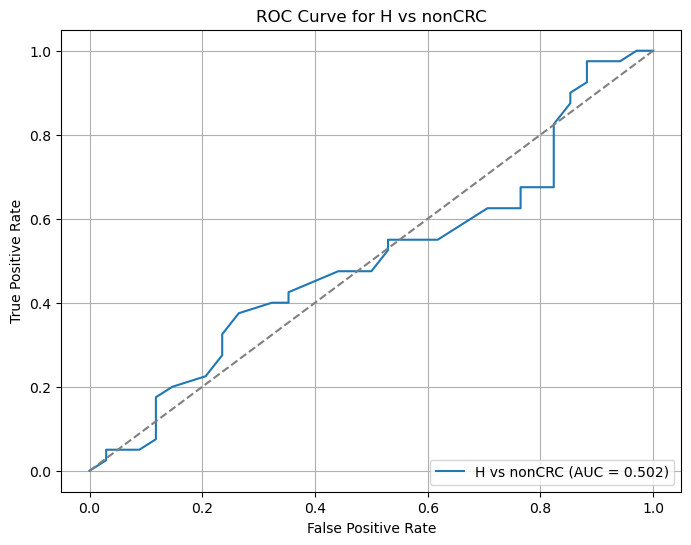

LASSO Features for H vs nonCRC:


In [19]:
##### H vs nonCRC: let's run a RF using the most important features from LASSO

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

 # Ensure otu_columns reflects the current training dataset
otu_columns = X_train_noncrc.columns  

X_train_noncrc_selected = X_train_noncrc[lasso_selected_features_noncrc]
X_test_noncrc_selected = X_test_noncrc[lasso_selected_features_noncrc]

# Train Random Forest on selected features
rf_noncrc_selected = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_noncrc_selected.fit(X_train_noncrc_selected, y_train_noncrc)

# Predictions and probabilities
y_pred_noncrc = rf_noncrc_selected.predict(X_test_noncrc_selected)
y_prob_noncrc = rf_noncrc_selected.predict_proba(X_test_noncrc_selected)[:, 1]  # Probability for positive class (nonCRC)

# Evaluate performance
accuracy_noncrc = accuracy_score(y_test_noncrc, y_pred_noncrc)
recall_noncrc = recall_score(y_test_noncrc, y_pred_noncrc, pos_label=2)
auc_noncrc = roc_auc_score(y_test_noncrc, y_prob_noncrc)

print("=== H vs nonCRC ===")
print(f"Accuracy: {accuracy_noncrc:.3f}")
print(f"Recall: {recall_noncrc:.3f}")
print(f"AUC-ROC: {auc_noncrc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_noncrc, y_pred_noncrc))

# Plot ROC curve
fpr_noncrc, tpr_noncrc, _ = roc_curve(y_test_noncrc, y_prob_noncrc, pos_label=2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_noncrc, tpr_noncrc, label=f"H vs nonCRC (AUC = {auc_noncrc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for H vs nonCRC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("LASSO Features for H vs nonCRC:")


🔍 **Observation: The ROC curve for H vs nonCRC lies close to the diagonal line (random classifier), suggesting limited discriminative power.**

 **This may reflect a high similarity between nonCRC and healthy microbiomes, making binary classification inherently challenging.**



In [51]:
### CRC vs. Healthy Classification

#### ML pipeline########

def run_ml_pipeline(X_train, X_test, y_train, y_test, model, param_grid, scale=False, cv_folds=5, model_name="Model"):
    """
    Runs an ML pipeline with optional scaling, GridSearchCV, cross-validation, evaluates performance, and plots ROC curve.

    Args:
        X_train (DataFrame): Preprocessed training features.
        X_test (DataFrame): Preprocessed test features.
        y_train (Series): Training labels.
        y_test (Series): Testing labels.
        model (sklearn model): The model to use in the pipeline.
        param_grid (dict): Hyperparameter grid for GridSearchCV.
        scale (bool): Whether to apply StandardScaler (needed for SVM and similar models).
        cv_folds (int): Number of cross-validation folds.
        model_name (str): Name of the model (for labeling outputs).

    Returns:
        dict: Model performance metrics.
    """
    # Define pipeline steps
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))  # Apply scaling if needed
    steps.append(('model', model))  # Add model as the final step

    # Define pipeline
    ml_pipeline = Pipeline(steps)

    # Perform Grid Search with Cross-Validation
    print(f"\n Running {model_name}...")
    grid_search = GridSearchCV(ml_pipeline, param_grid, cv=cv_folds, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # # Retrieve best model after grid search
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"\n Best Parameters for {model_name}: {best_params}")

    # Cross-validation AUC
    cv_auc = cross_val_score(best_model, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    print(f"\n Cross-Validation AUC Scores for {model_name}: {cv_auc}")
    print(f"🔹 Mean AUC: {np.mean(cv_auc):.3f}, Std Dev: {np.std(cv_auc):.3f}")

    # Predictions and probabilities
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    print(f"\n===  {model_name} Final Results ===")
    print(f" Accuracy: {accuracy:.3f}")
    print(f" AUC-ROC: {auc_roc}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot ROC curve if applicable
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_roc:.3f})", linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    return {"accuracy": accuracy, "auc_roc": auc_roc, "best_params": best_params}


**Model Setup & Hyperparameter Grids:**

**I define three machine learning models — Random Forest, SVM, and XGBoost — along with their hyperparameter** **grids for tuning via cross-validation. Class imbalance is addressed using `class_weight` or `scale_pos_weight`.**


In [52]:
# Random Forest Model with class_weight to address imbalance
rf_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 3})
param_grid_rf = {
    'model__n_estimators': [200, 300, 400],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Support Vector Machine with class_weight for imbalance
svm_model = SVC(probability=True, random_state=42, class_weight={0: 1, 1: 3})
param_grid_svm = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto']
}

# XGBoost with scale_pos_weight to counter class imbalance
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42, scale_pos_weight=3)
param_grid_xgb = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}


**Classification of CRC vs. Healthy using LASSO and RF Feature Selection**

**We apply three machine learning models (Random Forest, SVM, XGBoost) to classify CRC vs. Healthy samples using features selected by LASSO and Random Forest. This comparison helps evaluate how feature selection method impacts performance across classifiers.**



=== Running Models on LASSO-Selected Features ===

 Running Random Forest (LASSO)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Best Parameters for Random Forest (LASSO): {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 400}

 Cross-Validation AUC Scores for Random Forest (LASSO): [0.92222222 0.78383459 0.7537594  0.72556391 0.74269006]
🔹 Mean AUC: 0.786, Std Dev: 0.071

===  Random Forest (LASSO) Final Results ===
 Accuracy: 0.828
 AUC-ROC: 0.8247549019607843

 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        34
           1       0.85      0.71      0.77        24

    accuracy                           0.83        58
   macro avg       0.83      0.81      0.82        58
weighted avg       0.83      0.83      0.82        58



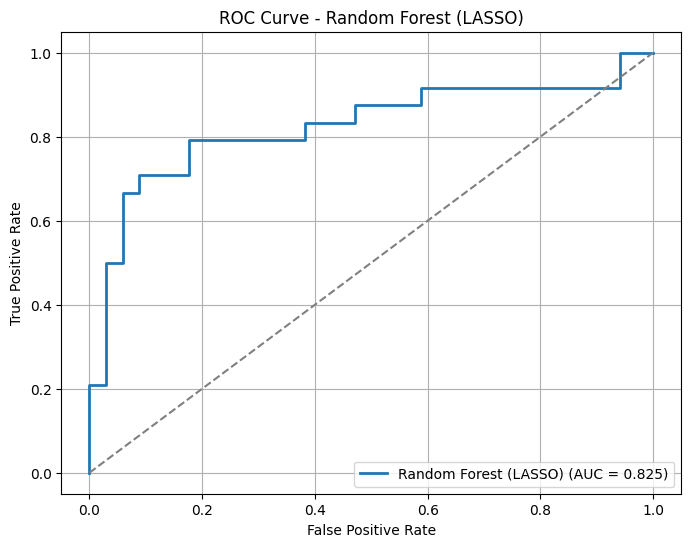


 Running SVM (LASSO)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Best Parameters for SVM (LASSO): {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

 Cross-Validation AUC Scores for SVM (LASSO): [0.92222222 0.91353383 0.90225564 0.89661654 0.81189084]
🔹 Mean AUC: 0.889, Std Dev: 0.040

===  SVM (LASSO) Final Results ===
 Accuracy: 0.862
 AUC-ROC: 0.8566176470588236

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        34
           1       0.90      0.75      0.82        24

    accuracy                           0.86        58
   macro avg       0.87      0.85      0.85        58
weighted avg       0.87      0.86      0.86        58



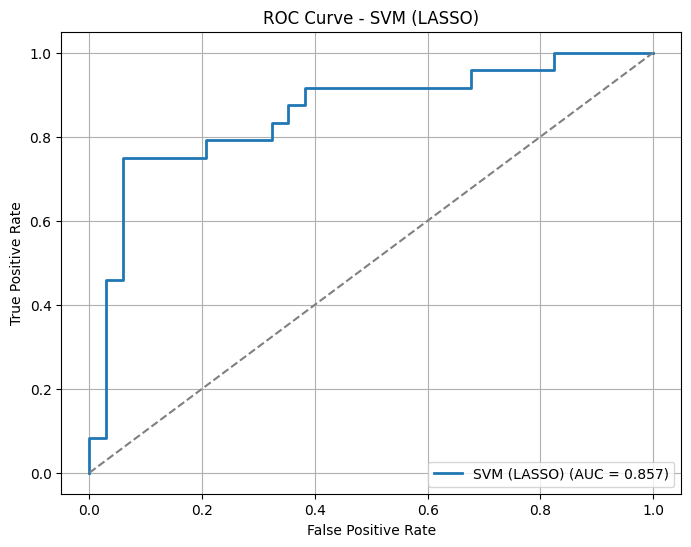


 Running XGBoost (LASSO)...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

 Best Parameters for XGBoost (LASSO): {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 9, 'model__n_estimators': 500, 'model__subsample': 0.8}

 Cross-Validation AUC Scores for XGBoost (LASSO): [0.90185185 0.7593985  0.73120301 0.70864662 0.73294347]
🔹 Mean AUC: 0.767, Std Dev: 0.069

===  XGBoost (LASSO) Final Results ===
 Accuracy: 0.845
 AUC-ROC: 0.8419117647058824

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        34
           1       0.83      0.79      0.81        24

    accuracy                           0.84        58
   macro avg       0.84      0.84      0.84        58
weighted avg       0.84      0.84      0.84        58



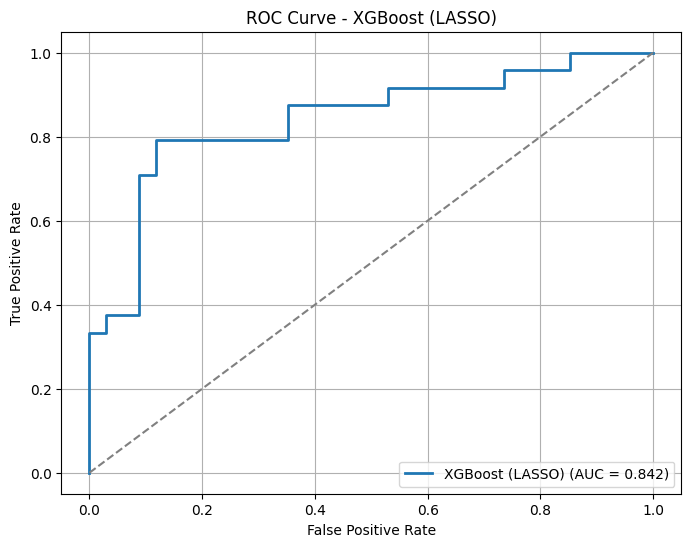


=== Running Models on RF-Selected Features ===

 Running Random Forest (RF)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Best Parameters for Random Forest (RF): {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 400}

 Cross-Validation AUC Scores for Random Forest (RF): [0.92962963 0.77067669 0.85902256 0.76879699 0.76998051]
🔹 Mean AUC: 0.820, Std Dev: 0.065

===  Random Forest (RF) Final Results ===
 Accuracy: 0.741
 AUC-ROC: 0.7598039215686275

 Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        34
           1       0.74      0.58      0.65        24

    accuracy                           0.74        58
   macro avg       0.74      0.72      0.72        58
weighted avg       0.74      0.74      0.74        58



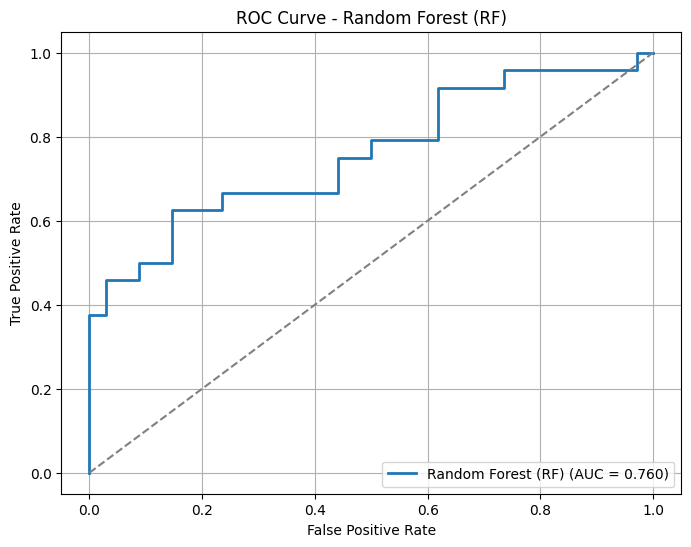


 Running SVM (RF)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Best Parameters for SVM (RF): {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'linear'}

 Cross-Validation AUC Scores for SVM (RF): [0.88333333 0.71992481 0.73496241 0.69172932 0.77192982]
🔹 Mean AUC: 0.760, Std Dev: 0.067

===  SVM (RF) Final Results ===
 Accuracy: 0.621
 AUC-ROC: 0.7389705882352942

 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        34
           1       0.54      0.58      0.56        24

    accuracy                           0.62        58
   macro avg       0.61      0.62      0.61        58
weighted avg       0.63      0.62      0.62        58



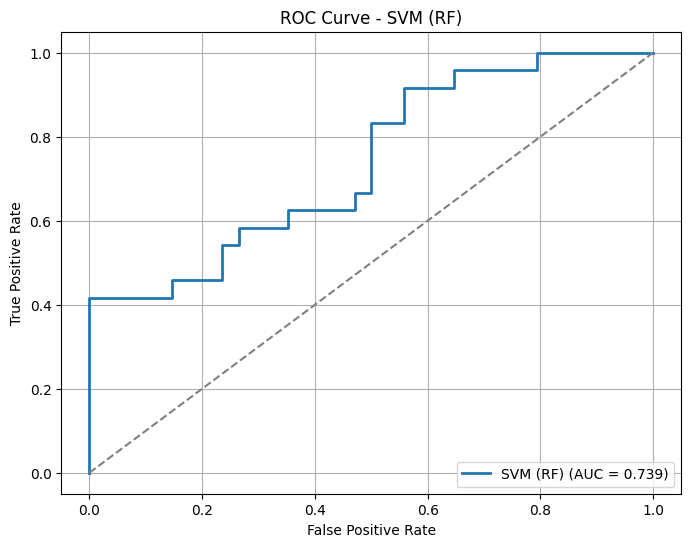


 Running XGBoost (RF)...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

 Best Parameters for XGBoost (RF): {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}

 Cross-Validation AUC Scores for XGBoost (RF): [0.88888889 0.80075188 0.85902256 0.79511278 0.78752437]
🔹 Mean AUC: 0.826, Std Dev: 0.040

===  XGBoost (RF) Final Results ===
 Accuracy: 0.741
 AUC-ROC: 0.7818627450980392

 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        34
           1       0.67      0.75      0.71        24

    accuracy                           0.74        58
   macro avg       0.74      0.74      0.74        58
weighted avg       0.75      0.74      0.74        58



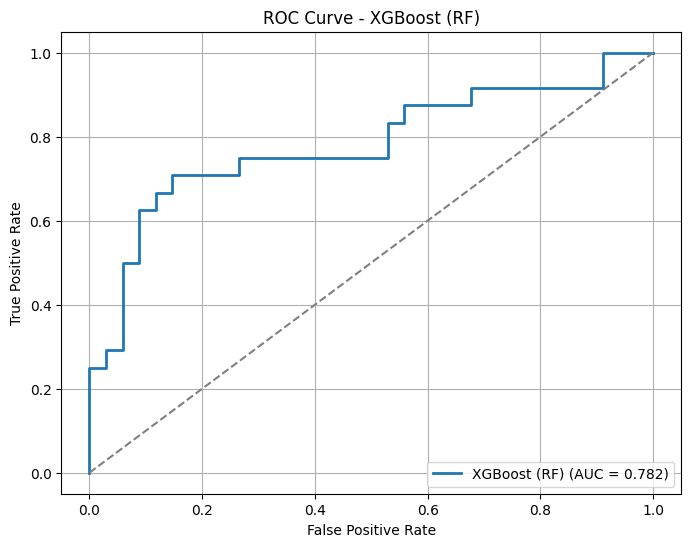

In [53]:
# Dictionary to store results for all model + feature selection combinations
comparison_results = {}

# ---------- LASSO-Selected Features ----------
print("\n=== Running Models on LASSO-Selected Features ===")
X_train_lasso = X_train_crc[lasso_selected_features_crc]
X_test_lasso = X_test_crc[lasso_selected_features_crc]

comparison_results["RF (LASSO)"] = run_ml_pipeline(
    X_train_lasso, X_test_lasso, y_train_crc, y_test_crc,
    model=rf_model, param_grid=param_grid_rf,
    scale=False, model_name="Random Forest (LASSO)"
)

comparison_results["SVM (LASSO)"] = run_ml_pipeline(
    X_train_lasso, X_test_lasso, y_train_crc, y_test_crc,
    model=svm_model, param_grid=param_grid_svm,
    scale=True, model_name="SVM (LASSO)"
)

comparison_results["XGBoost (LASSO)"] = run_ml_pipeline(
    X_train_lasso, X_test_lasso, y_train_crc, y_test_crc,
    model=xgb_model, param_grid=param_grid_xgb,
    scale=False, model_name="XGBoost (LASSO)"
)

# ---------- RF-Selected Features ----------
print("\n=== Running Models on RF-Selected Features ===")
X_train_rf = X_train_crc[rf_selected_features_crc]
X_test_rf = X_test_crc[rf_selected_features_crc]

comparison_results["RF (RF)"] = run_ml_pipeline(
    X_train_rf, X_test_rf, y_train_crc, y_test_crc,
    model=rf_model, param_grid=param_grid_rf,
    scale=False, model_name="Random Forest (RF)"
)

comparison_results["SVM (RF)"] = run_ml_pipeline(
    X_train_rf, X_test_rf, y_train_crc, y_test_crc,
    model=svm_model, param_grid=param_grid_svm,
    scale=True, model_name="SVM (RF)"
)

comparison_results["XGBoost (RF)"] = run_ml_pipeline(
    X_train_rf, X_test_rf, y_train_crc, y_test_crc,
    model=xgb_model, param_grid=param_grid_xgb,
    scale=False, model_name="XGBoost (RF)"
)


## ✅ Summary
See [README.md](https://github.com/ghazaleh-ostovar/crc-microbiome-classification/blob/main/README.md) for full results, model comparison, and key insights.

###  Final Summary - Colorectal Cancer Classification 
After evaluating multiple ML models, the best performance was achieved with:
✅ **Best Model:** **Support Vector Machine (SVM, RBF Kernel)**  
✅ **Performance Metrics:**
   - **Accuracy:** **86.2%**  
   - **AUC-ROC:** **0.856**  
   - **Precision (Class 1 - Cancer):** **90%**  
   - **Recall (Class 1 - Cancer):** **75%**  